In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from tqdm import tqdm
import csv
from sklearn.metrics import mean_squared_error
np.random.seed(5)

# Exercice 1

Génération de variables discretes

### Question 1

On souhaite générer une variable aléatoire $X$ qui suit la loi discrète suivante :
    $$\forall i \in \{ 1,...,n\}, ~\mathbb{P}(X = x_i) = p_i$$
    
Pour cela on tire un variable aléatoire $U \sim \mathcal{U}([0,1])$ et on cherche $i \in \{1,...,n\}$ tel que 
$$U \in \left[\sum\limits_{j=1}^{i-1}p_{j},\sum\limits_{j=1}^{i}p_j\right[$$
Alors, on renvoie $x_i$.

In [2]:
def discrete_distib(x,p,n):
    X = np.zeros(n)+x[0]
    p_sum = np.cumsum(p)
    for i in range(n):
        U = np.random.uniform()
        for j in range(len(p)):
            if U > p_sum[j]:
                X[i] = x[j+1]
    return X

Premier test avec la distribution uniforme sur $\{1,2,3\}$. On compare les histogrammes théoriques et empiriques. On constate que l'erreur est assez faible.

In [3]:
x = np.array([1,2,3])
p = np.array([1/3,1/3,1/3])
N = 10000
X = discrete_distib(x,p,N)

Text(0.5, 1.0, 'Histogramme théorique')

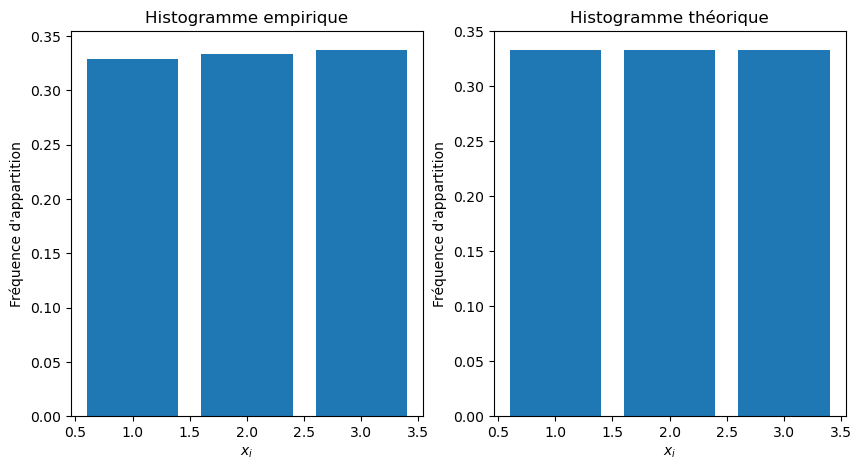

In [4]:
valeurs, counts = np.unique(X,return_counts=True)
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.bar(valeurs, counts/N)
plt.xlabel("$x_i$")
plt.ylabel("Fréquence d'appartition")
plt.title("Histogramme empirique")

plt.subplot(1,2,2)
plt.bar(x, p)
plt.xlabel("$x_i$")
plt.ylabel("Fréquence d'appartition")
plt.title("Histogramme théorique")


In [5]:
print("La différence maximale entre les fréquences empiriques et théoriques est de : " + str(np.max(counts/N - p)))
print("On a donc une erreur relative maximale de " + str(100*np.max(counts/N - p)/p[np.argmax(counts/N - p)]) + "%")

La différence maximale entre les fréquences empiriques et théoriques est de : 0.004166666666666707
On a donc une erreur relative maximale de 1.2500000000000122%


On essaye ensuite de générer une distribution discrète au hasard. Pour cela, on génère aléatoirement un entier $n$ entre 1 et 10. On génère ensuite des probabilités pour chaque élément de $\{1,...,n\}$ de manière cohérente (c'est à dire pour avoir une proba à la fin $\sum_i p_i = 1$). On compare ensuite les histogrammes théoriques et empiriques calculé grâce à notre méthode. Encore une fois, l'erreur commise est très faible.

In [6]:
n = int(10*np.random.uniform())
x = range(n)
p = np.zeros(n)
p[0] = np.random.uniform() 
for i in range(1,n-1):
    p[i] = p[i-1]*np.random.uniform() 
p[-1] = 1 - np.sum(p[:-1])

Text(0.5, 1.0, 'Histogramme théorique')

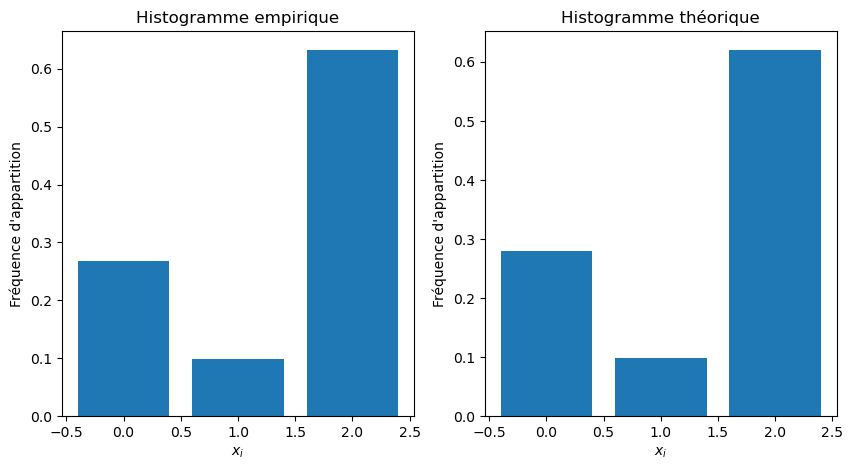

In [7]:
N = 10000
X = discrete_distib(x,p,N)
valeurs, counts = np.unique(X,return_counts=True)
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.bar(valeurs, counts/N)
plt.xlabel("$x_i$")
plt.ylabel("Fréquence d'appartition")
plt.title("Histogramme empirique")

plt.subplot(1,2,2)
plt.bar(x, p)
plt.xlabel("$x_i$")
plt.ylabel("Fréquence d'appartition")
plt.title("Histogramme théorique")


In [8]:
print("La différence maximale entre les fréquences empiriques et théoriques est de : " + str(np.max(counts/N - p)))
print("On a donc une erreur relative maximale de " + str(100*np.max(counts/N - p)/p[np.argmax(counts/N - p)]) + "%")

La différence maximale entre les fréquences empiriques et théoriques est de : 0.011991667008593998
On a donc une erreur relative maximale de 1.9316214637151143%


# Exercice 2

On commence par générer un exemple de mélange de 3 gaussiennes dont on a choisi les $\alpha_i$ et généré aléatoirement les $\mu_i,\Sigma_i$. Pour générer les $Z_i$, on utilise l'algorithme de l'exercice précédent.

In [9]:
n = 1000
m = 3
x = [0,1,2]
p = [1/10,1/3,1-1/10-1/3]
Z = discrete_distib(x,p,n)

In [10]:
mu = 20*stat.uniform.rvs(size=(m,2))
sigma = np.zeros((m,2,2))

for i in range(m):
    sigma[i,0,0] = 2*np.random.uniform()
    sigma[i,1,1] = 2*np.random.uniform()


X = np.array([stat.multivariate_normal.rvs(size=1,mean=mu[int(Z[i])],cov=sigma[int(Z[i])]) for i in range(n)])

Text(0.5, 1.0, 'Un exemple de mélange gaussien')

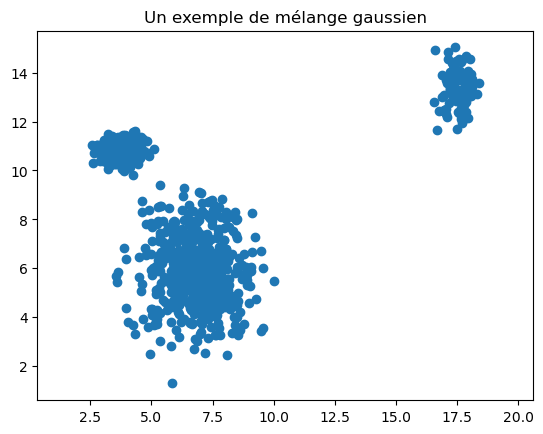

In [11]:
plt.scatter(X[:,0],X[:,1])
plt.axis("equal")
plt.title("Un exemple de mélange gaussien")

### Algorithme EM

On implémente ensuite l'algorithme EM dans le cas d'un mélange gaussien. Les détails des calculs sont dans le rapport. 

In [12]:
def EM(alpha_0,mu_0,sigma_0,max_it,X,m):
    (n,N) = X.shape
    
    alpha_t = alpha_0
    mu_t = mu_0
    sigma_t = sigma_0
    
    logL = np.zeros(max_it)
    
    for t in tqdm(range(max_it)):
        logL_t = np.zeros(n)
        #Calcul des p_ij^t
        p_t = np.zeros((n,m))
        for i in range(n):
            phi_times_alpha = np.array([stat.multivariate_normal.pdf(X[i],mean = mu_t[k], cov = sigma_t[k],allow_singular=True)*alpha_t[k] for k in range(m)])
            p_t[i,:] = phi_times_alpha/np.sum(phi_times_alpha)
            
            logL_t[i] = np.log(np.sum(phi_times_alpha))

        #Mise à jour des paramètres recherchés 
        alpha_t = 1/n * np.sum(p_t,axis = 0)
        
        for j in range(m):
            #Mise à jour de mu
            num_mu = np.array([p_t[i,j]*X[i] for i in range(n)])
            mu_t[j] = np.sum(num_mu,axis = 0)/np.sum(p_t[:,j])
            
            #Mise à jour de sigma
            num_sigma = np.array([p_t[i,j]*np.matmul(np.transpose(np.asmatrix(X[i] - mu_t[j])),np.asmatrix(X[i] - mu_t[j])) for i in range(n)])
            sigma_t[j] = np.sum(num_sigma,axis=0)/np.sum(p_t[:,j])

        #Calcul de la log vraisemblance
        logL[t] = np.sum(logL_t)
        
        
    return (alpha_t,mu_t,sigma_t,logL)    

On peut alors tester l'algorithme sur le mélange gaussien tiré précédement.

In [13]:
m = 3
alpha_0 = np.ones(m)/m
mu_0 = X[np.random.randint(0,n,m)]
sigma_0 = np.array([np.eye(2) for i in range(m)])
max_it = 50
(alpha_est,mu_est,sigma_est,logL) = EM(alpha_0,mu_0,sigma_0,max_it,X,m)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.00it/s]


On peut commencer par afficher le resultat ainsi que l'évolution de la log vraisemblance au cours des itérations. Qualitativement, les gaussiennes trouvées ont l'air de bien ressembler à celles générées. Pour la log vraisemblance, la première itération avait une log vraisemblance beaucoup plus faible que les suivantes, donc pour plus de lisibilité, on affiche également l'évolution de cette log vraisemblance à partir de l'itération 10. On voit que la logvraisemblance converge rapidement au bout d'une dizaine d'itérations.

Text(0.5, 1.0, 'Estimation des paramètres pour le modèle de mélange gaussien')

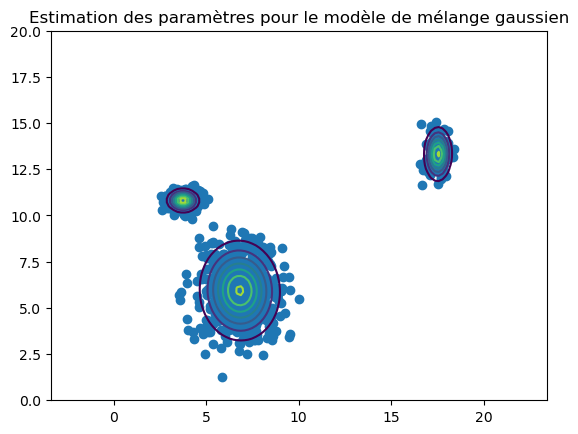

In [14]:
x = np.linspace(0, 20, num=100)
y = np.linspace(0, 20, num=100)
X_plot, Y_plot = np.meshgrid(x,y)

pos = np.empty(X_plot.shape + (2,))
pos[:, :, 0] = X_plot
pos[:, :, 1] = Y_plot

for k in range(m):
    val = stat.multivariate_normal.pdf(pos, mean = mu_est[k], cov = sigma_est[k])

    plt.contour(X_plot, Y_plot, val,extend='min')

plt.scatter(X[:,0],X[:,1])
plt.axis("equal")

plt.title("Estimation des paramètres pour le modèle de mélange gaussien")

Text(0.5, 0.98, 'Evolution de la log-vraisemblance au cours des itérations')

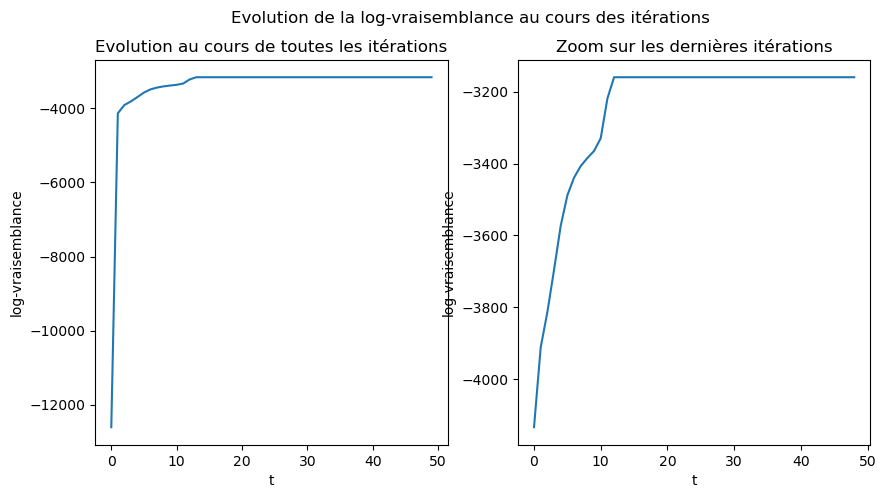

In [15]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(logL)
plt.title("Evolution au cours de toutes les itérations")
plt.xlabel("t")
plt.ylabel("log-vraisemblance")

plt.subplot(1,2,2)
plt.plot(logL[1:])
plt.title("Zoom sur les dernières itérations")
plt.xlabel("t")
plt.ylabel("log-vraisemblance")

plt.suptitle("Evolution de la log-vraisemblance au cours des itérations")


### Question 4

On compare les paramètres estimés aux paramètres théoriques. On remarque que dans certain cas, les gaussiennes estimées ne sont pas dans le même ordre que celles théorique. Il faut faire attention à cela quand on calcul les erreurs commises.
Dans notre cas, on commence par échanger les gaussiennes entre elles car l'EM a estimé la première en troisième, la deuxième en premier et la troisième en second. Cela ne change rien à l'interprétation des résultats, ça simplifie juste les calculs.

In [16]:
alpha_est[[0,1,2]] = alpha_est[[1,2,0]]
mu_est[[0,1,2]] = mu_est[[1,2,0]]
sigma_est[[0,1,2]] = sigma_est[[1,2,0]]

In [17]:
print("alpha théorique : " + str(p))
print("alpha estimé : " + str(alpha_est))
print("Erreur (MSE) sur alpha : " + str(mean_squared_error(p,alpha_est)))
print("\n")
print("mu théorique : " + str(mu))
print("mu estimé : " + str(mu_est))
print("Erreur (MSE) sur mu : " + str(mean_squared_error(mu,mu_est)))

print("\n")
print("sigma théorique : " + str(sigma))
print("sigma estimé : " + str(sigma_est))
print("Erreur (MSE) sur sigma : " + str(mean_squared_error(sigma.flatten(),sigma_est.flatten())))



alpha théorique : [0.1, 0.3333333333333333, 0.5666666666666667]
alpha estimé : [0.1        0.34692246 0.55307754]
Erreur (MSE) sur alpha : 0.00012310954222913238


mu théorique : [[17.49017527 13.31630442]
 [ 3.76399326 10.79772406]
 [ 6.82675801  5.93324776]]
mu estimé : [[17.53146234 13.32180276]
 [ 3.73902028 10.81187427]
 [ 6.80976998  5.93571652]]
Erreur (MSE) sur mu : 0.00047556999137160705


sigma théorique : [[[0.18414668 0.        ]
  [0.         0.55713286]]

 [[0.23181885 0.        ]
  [0.         0.10851347]]

 [[1.18087559 0.        ]
  [0.         1.6975385 ]]]
sigma estimé : [[[ 1.41128116e-01  6.47969997e-03]
  [ 6.47969997e-03  5.38996547e-01]]

 [[ 1.87134534e-01 -1.45149057e-03]
  [-1.45149057e-03  9.83724588e-02]]

 [[ 1.19454546e+00 -4.04790789e-02]
  [-4.04790789e-02  1.85252869e+00]]]
Erreur (MSE) sur sigma : 0.002654431075469834


On voit que l'erreur commise est très faible. L'algorithme EM arrive très bien à estimer les paramètres dans ce cas. Il faut tout de fois mentionner que les 3 gaussiennes choisies sont bien distinctes les unes des autres, elles ne se superposent pas. Quand les gaussiennes choisies à la base sont plus proches les unes des autres, l'erreur commise est plus élevée. 

### Question 5

On commence par importer les données et les visualiser.

In [18]:
with open('Data/Crude-BirthDeath-Rate.csv', 'r') as file:
    data = []
    reader = csv.reader(file)
    for l in reader:
        data.append(l)
data = np.array(data[1:],dtype=float)
n = len(data)

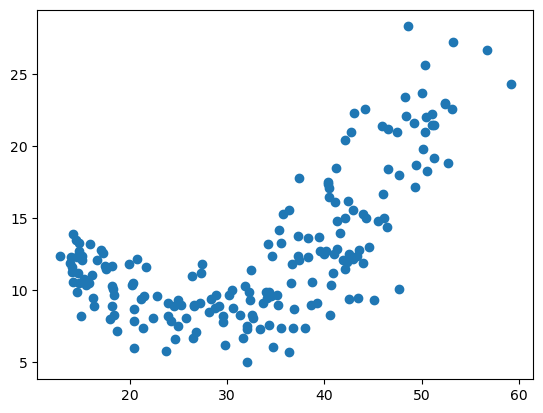

In [19]:
plt.scatter(data[:,0],data[:,1])

On applique l'algorithme EM sur ce jeu de données en faisant varier le nombre $m$ de gaussiennes. On affiche à chaque fois le résultat et on calcul le BIC. 

m =  1


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.60it/s]


m =  2


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.46it/s]


m =  3


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.57it/s]


m =  4


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.34it/s]


m =  5


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.58it/s]


m =  6


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.60it/s]


m =  7


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.59it/s]


m =  8


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.02it/s]


Le nombre de gaussienne minimisant le BIC est : 2


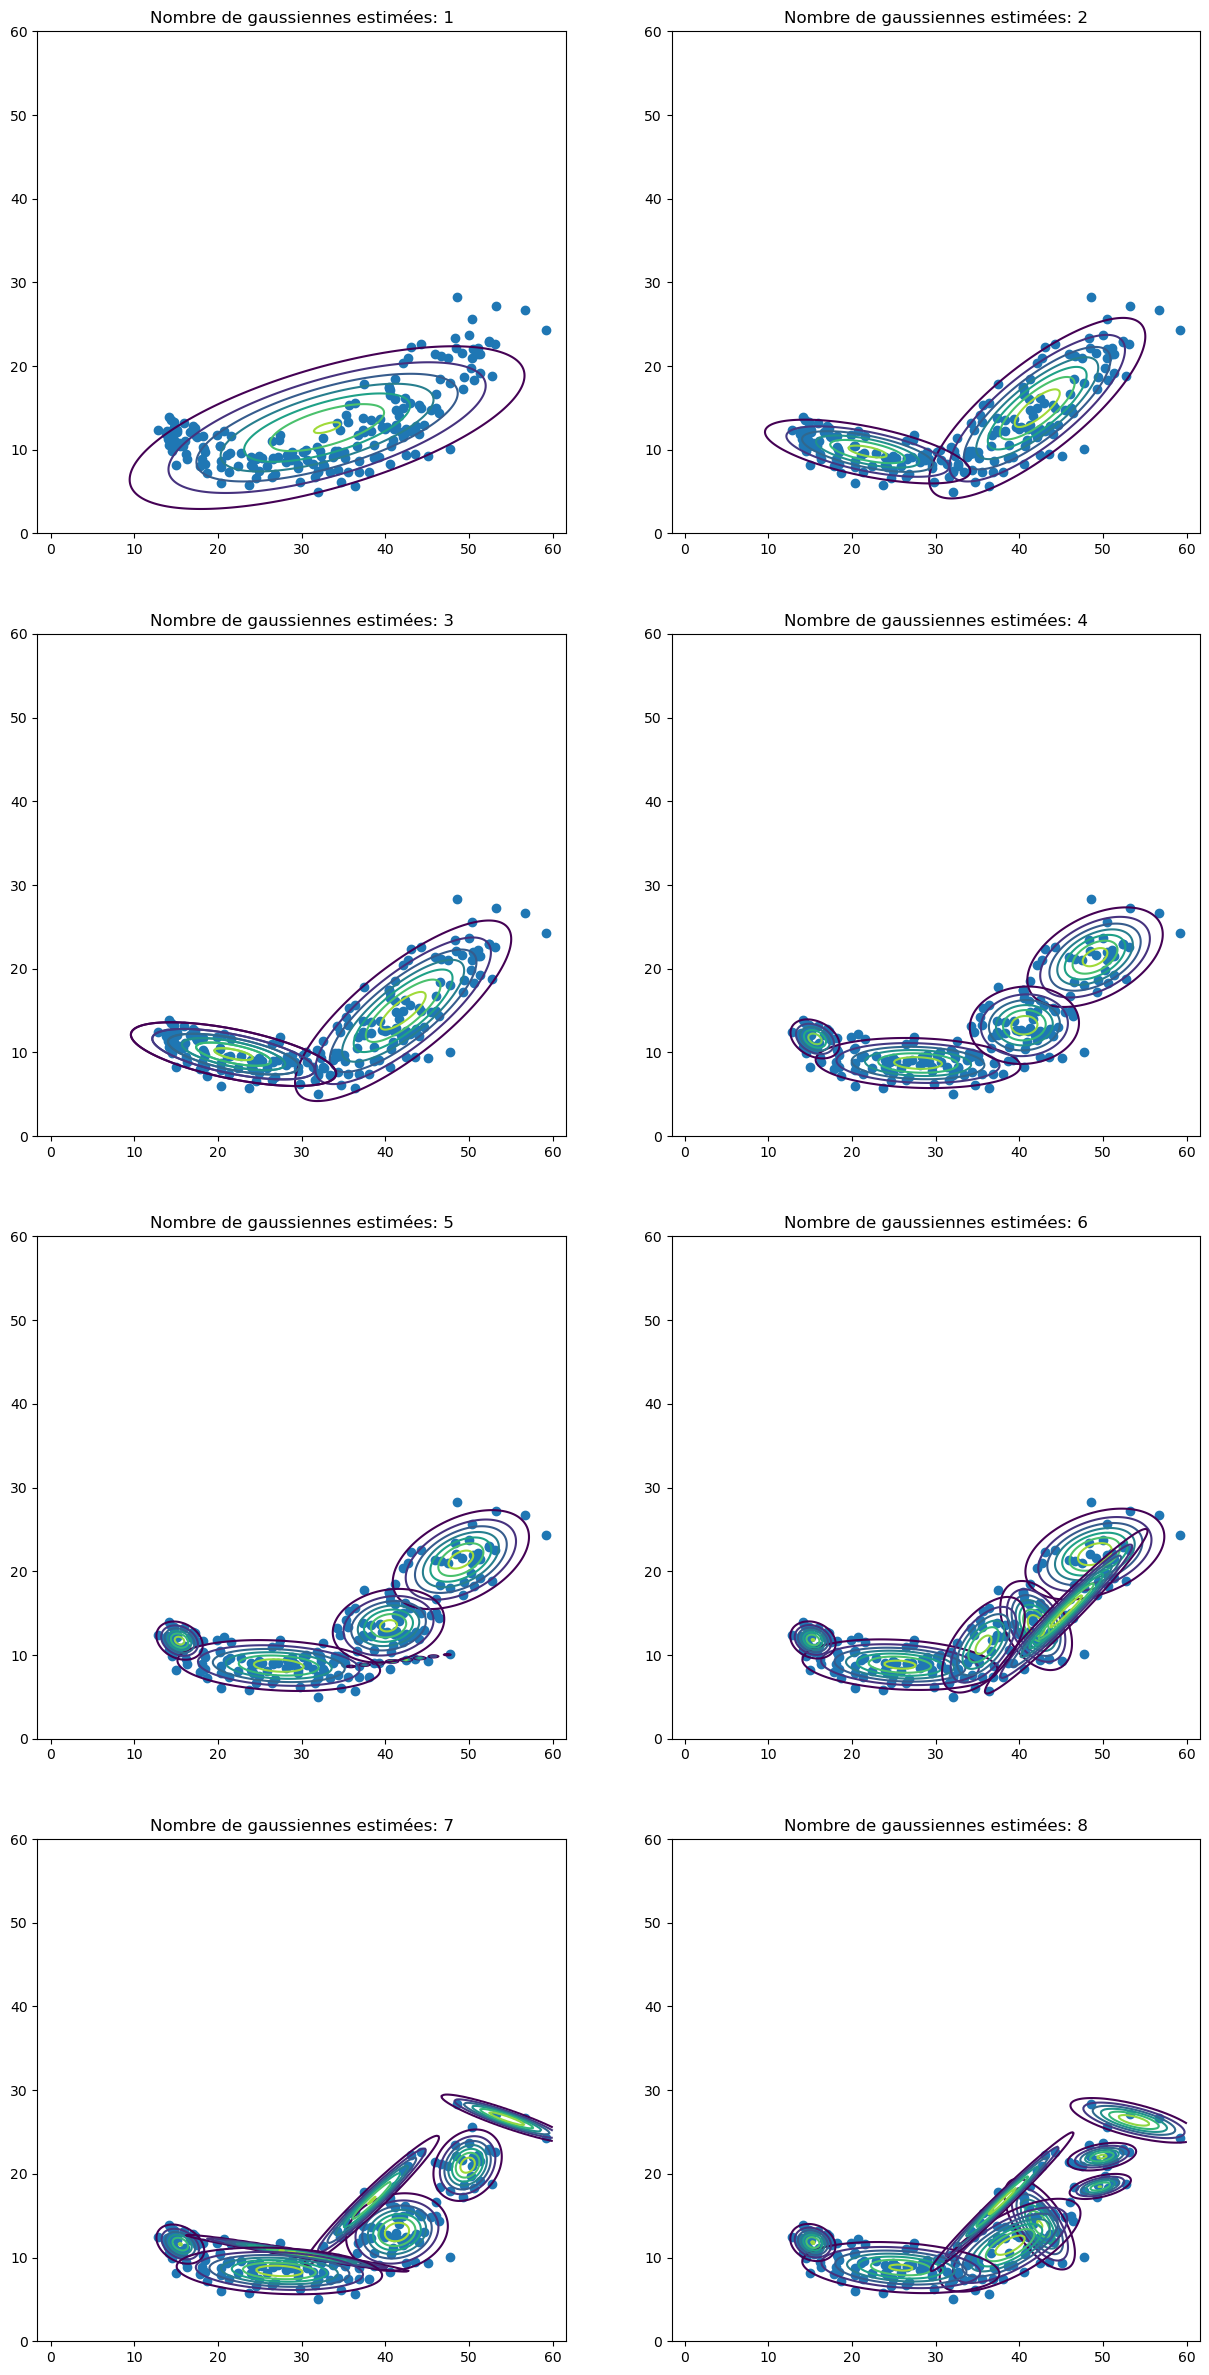

In [20]:
plt.figure(figsize = (15,30))
BIC = []
for m in range(1,9):
    print("m = ",m)
    alpha_0 = np.ones(m)/m
    mu_0 = data[np.random.randint(0,n,m)]
    sigma_0 = np.array([np.eye(2) for i in range(m)])
    max_it = 100
    (alpha_est,mu_est,sigma_est,logL) = EM(alpha_0,mu_0,sigma_0,max_it,data,m)
    BIC.append(-logL[-1] + 7*m*np.log(n)/2)
    
    plt.subplot(4,2,m)
    x = np.linspace(0, 60, num=300)
    y = np.linspace(0, 60, num=300)
    X_plot, Y_plot = np.meshgrid(x,y)

    pos = np.empty(X_plot.shape + (2,))
    pos[:, :, 0] = X_plot
    pos[:, :, 1] = Y_plot

    for k in range(m):
        val = stat.multivariate_normal.pdf(pos, mean = mu_est[k], cov = sigma_est[k])

        plt.contour(X_plot, Y_plot, val,extend='min')

    plt.scatter(data[:,0],data[:,1])
    plt.axis("equal")

    plt.title("Nombre de gaussiennes estimées: "+str(m))
print("Le nombre de gaussienne minimisant le BIC est : " + str(np.argmin(BIC)+1))

# Exercice 3

In [21]:
mu = 0.8
sigma = np.sqrt(1.5)


def f(x):
    if x < 0:
        return 0
    else:
        return 2*np.sin(np.pi/1.5*x)
    
def p(x):
    if x < 0:
        return 0
    else:
        return x**0.65*np.exp(-x**2/2)

def q(x,mu,sigma):
    return 2/np.sqrt(2*np.pi*sigma**2)*np.exp(-(mu-x)**2/(2*sigma**2))

On commence par visuler les différentes fonctions que l'on va manipuler.

Text(0.5, 1.0, 'Représentation graphique des fonctions $f$,$p$ et $q$ \n pour $\\mu = 0.8$')

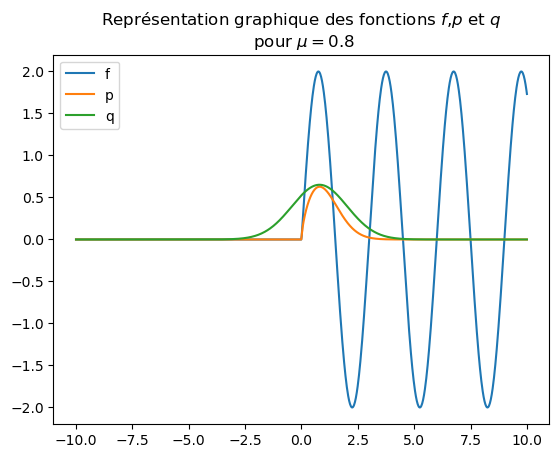

In [22]:
x = np.linspace(-10,10,1000)
plt.plot(x,[f(x_) for x_ in x],label="f")
plt.plot(x,[p(x_) for x_ in x],label="p")
plt.plot(x,[q(x_,mu,sigma) for x_ in x],label="q")
plt.legend()
plt.title("Représentation graphique des fonctions $f$,$p$ et $q$ \n pour $\\mu = 0.8$")

### Question 1

On implémente ensuite l'importance sampling pour la fonction $f$.

In [23]:
def importance_sampling(n,mu,sigma):
    p_list = np.zeros(n)
    q_list = np.zeros(n)
    f_list = np.zeros(n)
    for i in range(n):
        X = stat.norm.rvs(size=1,loc=mu,scale=sigma**2)
        while X < 0:
            X = stat.norm.rvs(size=1,loc=mu,scale=sigma**2)

        p_list[i] = p(X)
        q_list[i] = q(X,mu,sigma)
        f_list[i] = f(X)

    omega = p_list/q_list
    omega_tile = n*omega/np.sum(omega)

    return (np.sum(omega_tile*f_list)/n, omega_tile)

### Question 2

On calcule la valeur approchée de $\mathbb{E}_p[f(X)]$ en utilisant l'algorithme de l'importance sampling. On fait varier la taille $n$ de l'échantillon $(X_1,...,X_n)$ de $n = 10$ à $10^4$. On plot également les poids calculés.

Pour n = 10 le résultat est : -0.004127529475074887
Pour n = 100 le résultat est : 0.6347919538503496
Pour n = 1000 le résultat est : 0.7182139843673109
Pour n = 10000 le résultat est : 0.6809140474125618


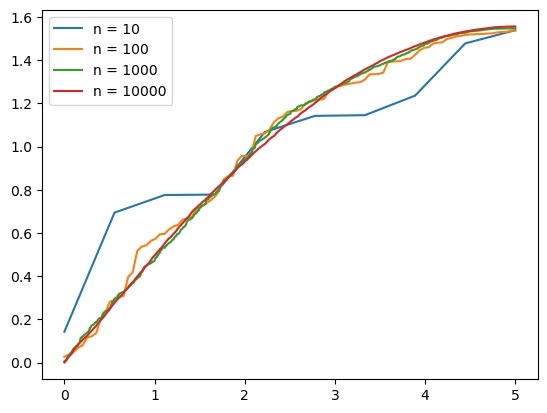

In [24]:
n = [10,100,10**3,10**4]
for i in range(len(n)):
    (res,weights_1) = importance_sampling(n[i],mu,sigma)
    print("Pour n = " + str(n[i]) + " le résultat est : " + str(res))
    plt.plot(np.linspace(0,5,len(weights_1)),sorted(weights_1),label = "n = " + str(n[i]))
plt.legend()

On itère le même calcul un grand nombre de fois afin de calculer numériquement l'esperance et la variance de notre estimateur de $\mathbb{E}_p[f(X)]$.

In [25]:
n = [10,100,10**3,10**4]
N = 100
for i in range(len(n)):
    estimation = []
    for j in tqdm(range(N)):
        (res,weights_1) = importance_sampling(n[i],mu,sigma)
        estimation.append(res)
    print("Pour n = " + str(n[i]) + " l'esperance est : " + str(np.mean(estimation)) + " et la variance est : " + str(np.var(estimation)))
   

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1808.58it/s]


Pour n = 10 l'esperance est : 0.6705788051854735 et la variance est : 0.14342533741251498


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 183.34it/s]


Pour n = 100 l'esperance est : 0.6697684782167228 et la variance est : 0.0179911035663765


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.64it/s]


Pour n = 1000 l'esperance est : 0.6809035144729008 et la variance est : 0.0016164977648861858


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]

Pour n = 10000 l'esperance est : 0.683408473767289 et la variance est : 0.0001967269520846845


L'espérance de notre échantillon a l'air de converger vers une valeur ( $\sim$ 0.68) et on voit que la variance diminue fortement, ce qui est bon signe. On peut donc estimer que la valeur de l'intégrale cherchée est environ 0.68.

On change la moyenne de $q$, on la fixe désormais à $\mu = 6$ et on réitère les mêmes calculs.

Text(0.5, 1.0, 'Représentation graphique des fonctions $f$,$p$ et $q$ \n pour $\\mu = 6$')

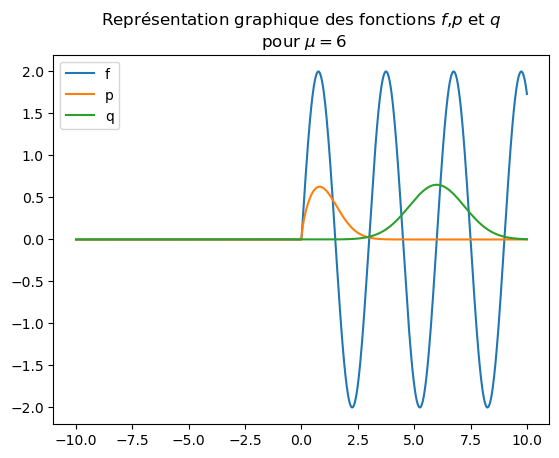

In [26]:
mu = 6
x = np.linspace(-10,10,1000)
plt.plot(x,[f(x_) for x_ in x],label="f")
plt.plot(x,[p(x_) for x_ in x],label="p")
plt.plot(x,[q(x_,mu,sigma) for x_ in x],label="q")
plt.legend()
plt.title("Représentation graphique des fonctions $f$,$p$ et $q$ \n pour $\\mu = 6$")

Pour n = 10 le résultat est : 1.957323065727391
Pour n = 100 le résultat est : -1.7438818615285008
Pour n = 1000 le résultat est : 1.4326785044508772
Pour n = 10000 le résultat est : 0.7913438168109502


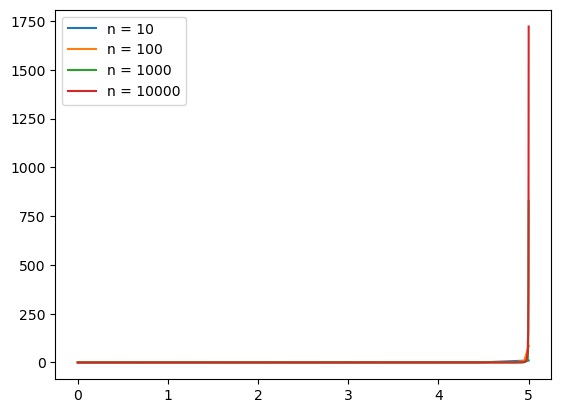

In [27]:
for i in range(len(n)):
    (res,weights_2) = importance_sampling(n[i],mu,sigma)
    print("Pour n = " + str(n[i]) + " le résultat est : " + str(res))
    plt.plot(np.linspace(0,5,len(weights_2)),sorted(weights_2),label = "n = " + str(n[i]))
plt.legend()

In [28]:
n = [10,100,10**3,10**4]
N = 100
for i in range(len(n)):
    estimation = []
    for j in tqdm(range(N)):
        (res,weights_1) = importance_sampling(n[i],mu,sigma)
        estimation.append(res)
    print("Pour n = " + str(n[i]) + " l'esperance est : " + str(np.mean(estimation)) + " et la variance est : " + str(np.var(estimation)))
   

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2184.50it/s]


Pour n = 10 l'esperance est : 0.2845726857360413 et la variance est : 1.8030627205658738


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 227.15it/s]


Pour n = 100 l'esperance est : -0.7578952921680383 et la variance est : 1.1692747366353418


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.98it/s]


Pour n = 1000 l'esperance est : 0.3735381644783994 et la variance est : 1.2627995414387527


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

Pour n = 10000 l'esperance est : 1.1336095879568822 et la variance est : 0.08668750333831456


Les résultats ne sont pas du tout les mêmes que précédemment. Cela est du au fait que le support de $q$ et celui de $p$ ne coïncident pas, comme on peut le voir que le graphique précédent. Or, pour que l'importance sampling fonctionne, on veut que $Supp(f \times p) \subset Supp(q)$ ce qui n'est pas le cas ici. On voit alors que les poids calculés sont très mauvais, car les échantillons générés vont être dans une zone où $p$ est quasi nulle.

Enfin, on voit que la variance ne diminue pas autant que précédement ce qui nous pousse à être vigilant sur la véracité de ces résultats.

### Question 5

On commence par afficher des points tirés dans la densité $\nu$ pour voir à quoi elle ressemble. On peut effectivement se convaincre que l'on va pouvoir l'approcher par un mélange de gaussiennes.

Text(0.5, 1.0, 'Nuage de point tiré à partir de la vraie densité $\\nu$')

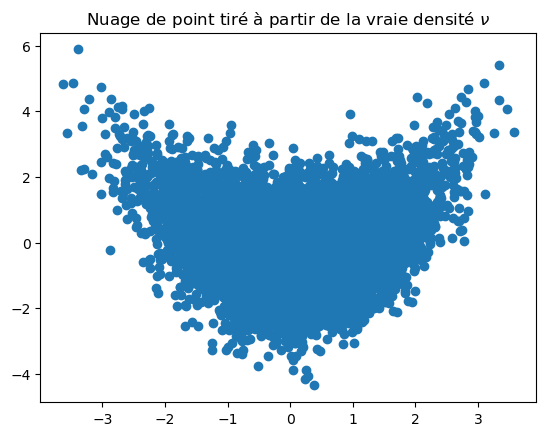

In [29]:
d = 5
sigma_1 = 1
b = 0.4

n = 10000


X = stat.multivariate_normal.rvs(size=n,mean=np.zeros(d))
X[:,1] = X[:,1] + b*(X[:,0]**2 - sigma)
plt.scatter(X[:,0],X[:,1])
plt.title("Nuage de point tiré à partir de la vraie densité $\\nu$")

On modifie ensuite l'algorithme EM implémenté ci-dessus afin de prendre en compte l'importance sampling.

In [30]:
def nu(X, d, sigma, b):
    Sigma = np.eye(d)
    Sigma[0,0] = sigma**2
    
    X_temp = np.copy(X)
    X_temp[:,1] = X[:,1] - b*(X[:,0]**2 - sigma)
    return stat.multivariate_normal.pdf(X_temp,mean = np.zeros(d),cov=Sigma, allow_singular=True)

def q(X, n, alpha, mu,sigma):
    somme = np.zeros((n,alpha.size))
    for i in range(alpha.size):
        somme[:,i] = stat.multivariate_normal.pdf(X,mean = mu[i], cov = sigma[i],allow_singular = True)*alpha[i]
    return np.sum(somme,axis = 1)

    
def sample_X(n, alpha, mu, sigma):
    Z = discrete_distib(np.array(range(alpha.size)),alpha,n)
    X = np.array([stat.multivariate_normal.rvs(size=1,mean=mu[int(Z[i])],cov=sigma[int(Z[i])]) for i in range(n)])
    return X

def pop_monte_carlo(alpha_0,mu_0,sigma_0,max_it,n,m,b,d,sigma):
    
    alpha_t = alpha_0
    mu_t = mu_0
    sigma_t = sigma_0
    
    logL = np.zeros(max_it)
    
    for t in tqdm(range(max_it)):
        #Tirage des va (X_1^(t),...,X_n^(t))
        X_t = sample_X(n,alpha_t,mu_t,sigma_t)
        
        #Calcul des poids de l'importance sampling
        nu_list = nu(X_t, d, sigma, b)
        q_list = q(X_t, n,alpha_t, mu_t, sigma_t)

        omega = nu_list/q_list
        omega_tilde = n*omega/np.sum(omega)
        
        
        logL_t = np.zeros(n)
        #Calcul des p_ij^t
        p_t = np.zeros((n,m))
        for i in range(n):
            phi_times_alpha = np.array([stat.multivariate_normal.pdf(X_t[i],mean = mu_t[k], cov = sigma_t[k], allow_singular = True)*alpha_t[k] for k in range(m)])
            p_t[i,:] = phi_times_alpha/np.sum(phi_times_alpha)
            
            logL_t[i] = np.log(np.sum(phi_times_alpha))
        
        #Prise en compte de l'importance sampling
        for j in range(m):
            p_t[:,j] = p_t[:,j]*omega_tilde
        
        #Mise à jour des paramètres recherchés 
        alpha_t = np.sum(p_t,axis = 0)
        
        for j in range(m):
            #Mise à jour de mu
            num_mu = np.array([p_t[i,j]*X_t[i] for i in range(n)])
            mu_t[j] = np.sum(num_mu,axis = 0)/alpha_t[j]
            
            #Mise à jour de sigma
            num_sigma = np.array([p_t[i,j]*np.matmul(np.transpose(np.asmatrix(X_t[i] - mu_t[j])),np.asmatrix(X_t[i] - mu_t[j])) for i in range(n)])
            sigma_t[j] = np.sum(num_sigma,axis=0)/alpha_t[j]
        
        alpha_t /= np.sum(alpha_t)

        #Calcul de la log vraisemblance
        logL[t] = np.sum(logL_t)
        
        
    return (alpha_t,mu_t,sigma_t,logL)        
    

On peut alors tester notre algorithme pour estimer la densité $\nu$. On choisit, arbitrairement pour commencer, $m = 3$ le nombre de gaussiennes à estimer. On voit que qualitativement, le mélange de gaussiennes obtenu se superpose bien avec la vraie densité $\nu$. Notre algorithme fonctionne donc.

In [31]:
m = 3
d = 5
n = 1000
alpha_0 = np.ones(m)/m
mu_0 = 2*(stat.uniform.rvs(size=(m,d))-0.5)
sigma_0 = np.array([np.eye(d) for i in range(m)])
max_it = 100
(alpha_est,mu_est,sigma_est,logL) = pop_monte_carlo(alpha_0,mu_0,sigma_0,max_it,n,m,b,d,sigma)

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.20it/s]


Text(0.5, 1.0, "Nuage de points tiré à partir de la vraie densité $\\nu$ auquel \n on a superposé les gaussiennes estimées par l'algorithme EM modifié")

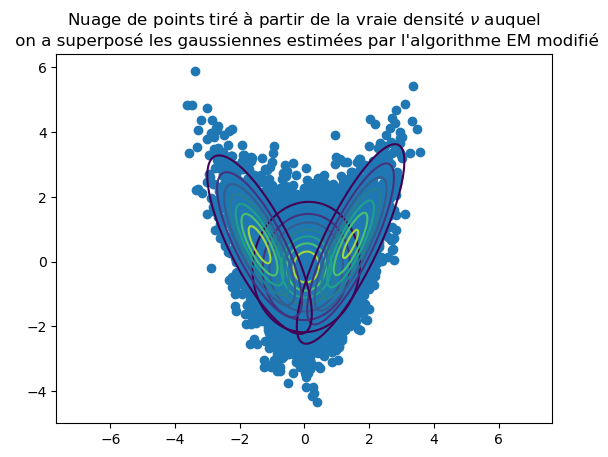

In [32]:
plt.scatter(X[:,0],X[:,1])
x = np.linspace(-5, 5, num=300)
y = np.linspace(-5, 5, num=300)
X_plot, Y_plot = np.meshgrid(x,y)

pos = np.empty(X_plot.shape + (2,))
pos[:, :, 0] = X_plot
pos[:, :, 1] = Y_plot

for k in range(m):
    val = stat.multivariate_normal.pdf(pos, mean = mu_est[k,:2], cov = sigma_est[k,:2,:2])
    plt.contour(X_plot,Y_plot, val,extend='min')
plt.axis('equal')
plt.title("Nuage de points tiré à partir de la vraie densité $\\nu$ auquel \n on a superposé les gaussiennes estimées par l'algorithme EM modifié")

On tire des points dans notre mélange de gaussiennes estimé afin de voir si ce nugae de points estimé ressemble à celui tiré à partir de la vraie densité $\nu$. On remarque que c'est bien le cas. 

Text(0.5, 1.0, 'Nuage de points tiré à partir du mélange gaussien estimé')

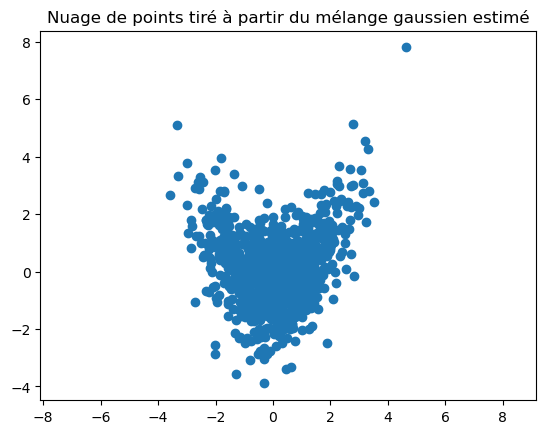

In [33]:
X_est = sample_X(n,alpha_est,mu_est,sigma_est)
plt.scatter(X_est[:,0],X_est[:,1])
plt.axis('equal')
plt.title("Nuage de points tiré à partir du mélange gaussien estimé")

m =  1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.29it/s]


m =  2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.67it/s]


m =  3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.24it/s]


m =  4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


m =  5


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.84it/s]


m =  6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.43it/s]


m =  7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.15it/s]


m =  8


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


Le nombre de gaussienne minimisant le BIC est : 5


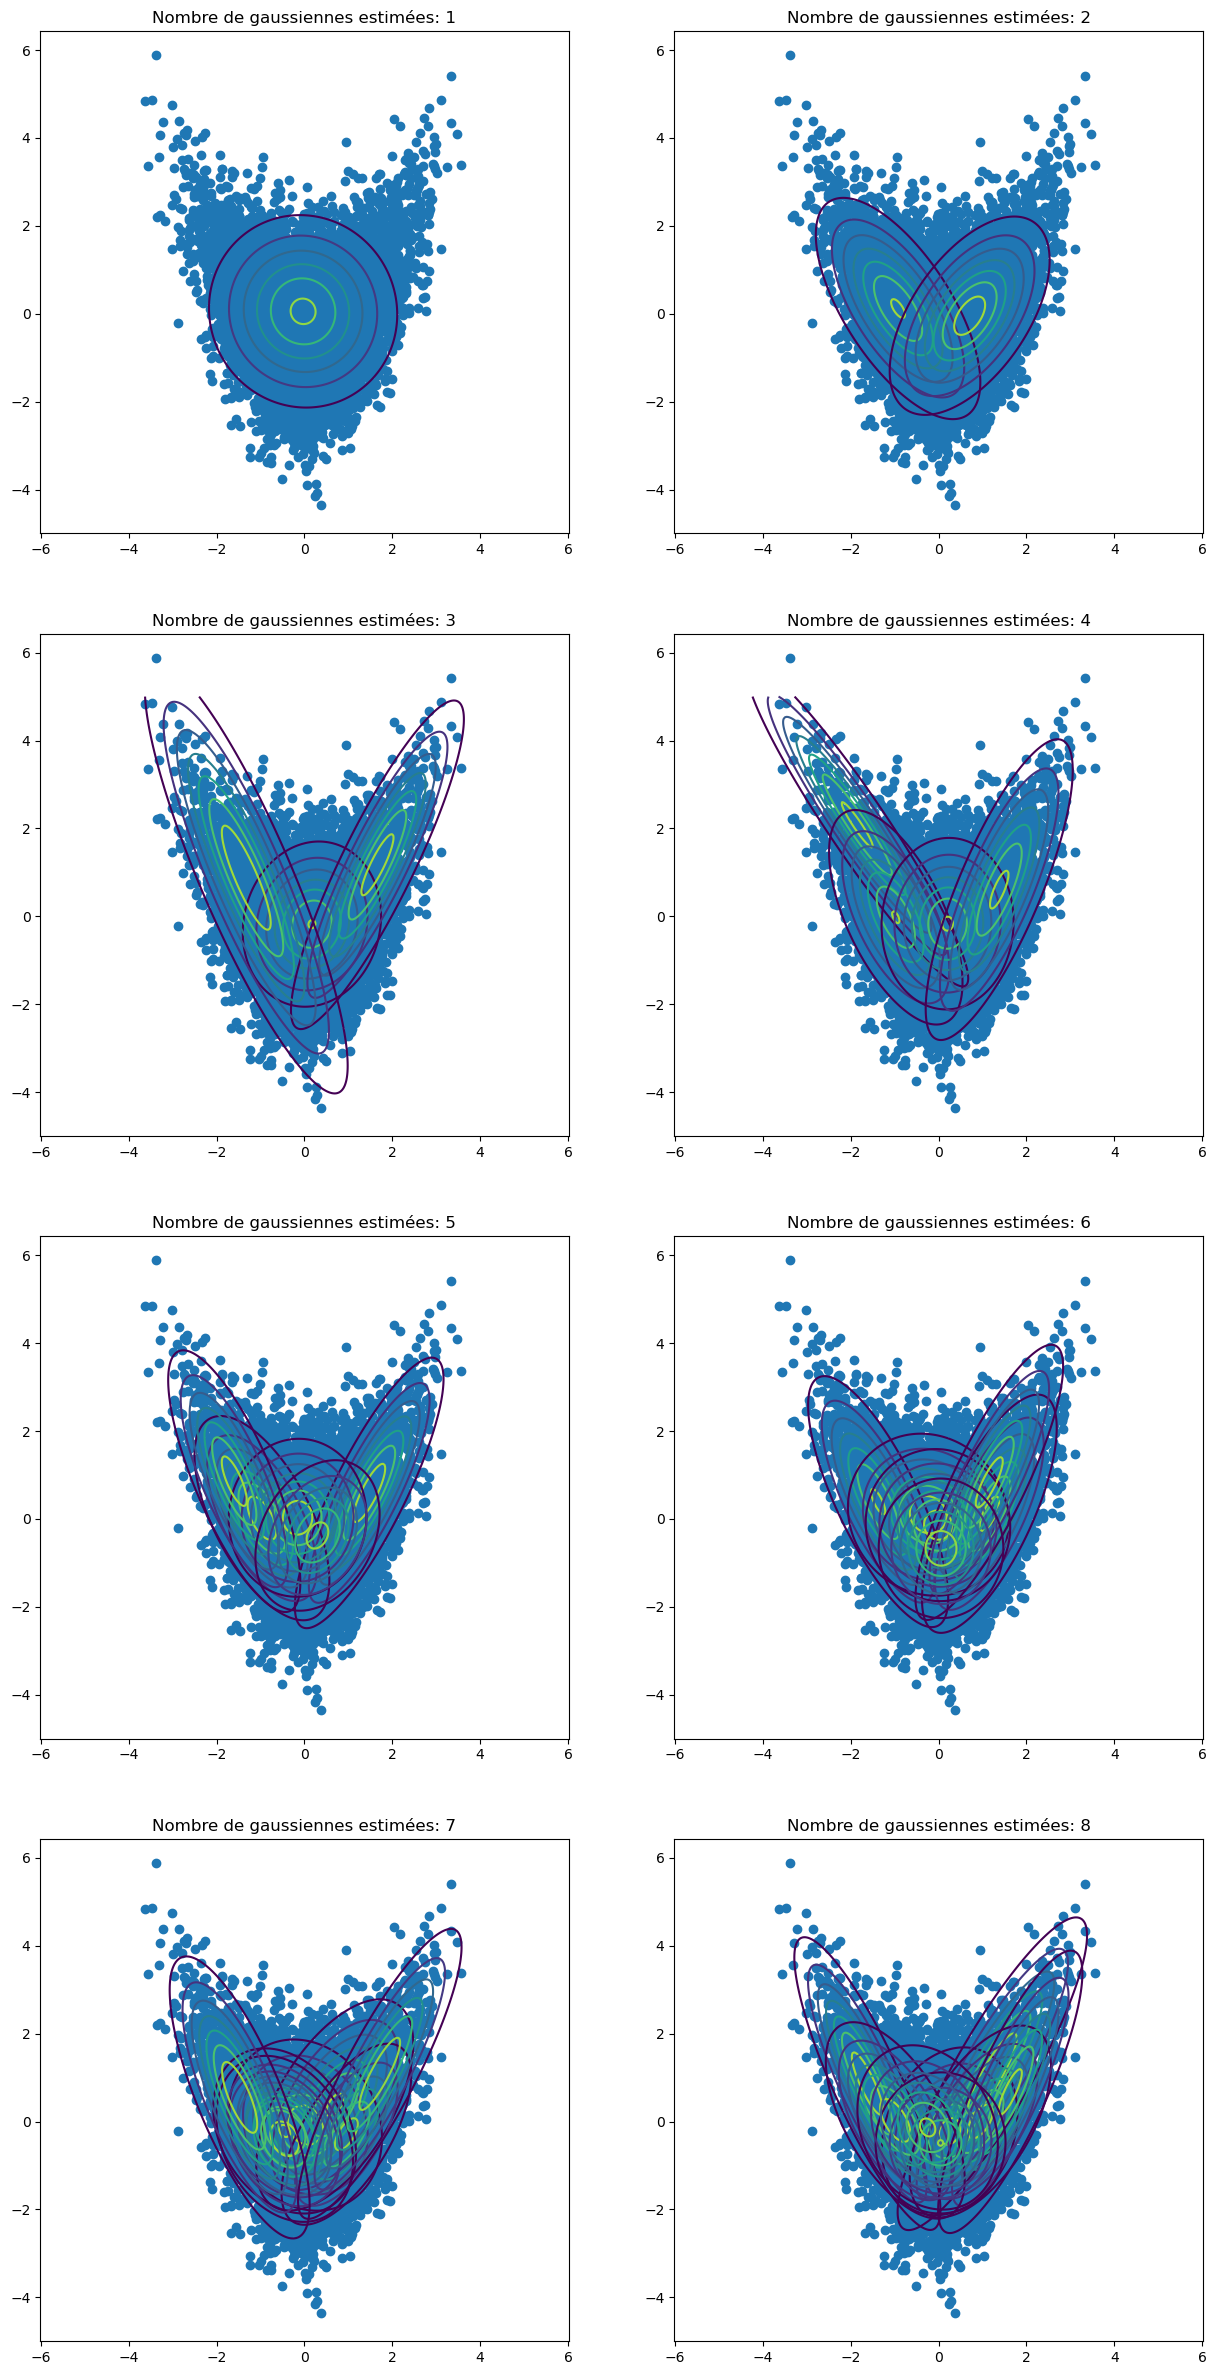

In [34]:
plt.figure(figsize = (15,30))
BIC = []
for m in range(1,9):
    print("m = ",m)
    alpha_0 = np.ones(m)/m
    mu_0 = 2*(stat.uniform.rvs(size=(m,d))-0.5)
    sigma_0 = np.array([np.eye(d) for i in range(m)])
    max_it = 50
    (alpha_est,mu_est,sigma_est,logL) = pop_monte_carlo(alpha_0,mu_0,sigma_0,max_it,n,m,b,d,sigma)
    BIC.append(-logL[-1] + 5*m*np.log(n)/2)
    
    plt.subplot(4,2,m)
    x = np.linspace(-5, 5, num=300)
    y = np.linspace(-5, 5, num=300)
    X_plot, Y_plot = np.meshgrid(x,y)

    pos = np.empty(X_plot.shape + (2,))
    pos[:, :, 0] = X_plot
    pos[:, :, 1] = Y_plot

    for k in range(m):
        val = stat.multivariate_normal.pdf(pos, mean = mu_est[k,:2], cov = sigma_est[k,:2,:2])

        plt.contour(X_plot, Y_plot, val,extend='min')

    plt.scatter(X[:,0],X[:,1])
    plt.axis("equal")

    plt.title("Nombre de gaussiennes estimées: "+str(m))
print("Le nombre de gaussienne minimisant le BIC est : " + str(np.argmin(BIC)+1))

On a ici que le nombre de gaussiennes minimisant le critère BIC est 5. Qualitativement, on pourrait penser que le nombre de gausienne permettant d'estimer le mieux cette densité est 3, mais le critère BIC ne nous donne pas raison. 